- Currently using a pretty naive minimization algorithm. It will approximate the gradient and move in that direction. This requires lots of function calls. 
- We have no way to get the Hessian - which is needed for the variance estimates of our parameters. 

### Automatic differentiation - how to differentiate an algorithm

Symbolic differentiation is what we learned in school, and software like SymPy, Wolfram and Mathematica do this well. But I want to differentiate the following:

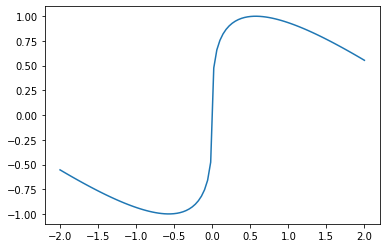

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


def f(x):
    y = 0.
    for i in range(100):
        y = np.sin(y + x)
    return y

x = np.linspace(-2, 2, 100)
plt.plot(x, [f(x_) for x_ in x])

Mathematically, it's something like:

$$f(x) = \sin(x + \sin(x + \sin(x + ...\sin(x)))...)$$

Good luck differentiating that and getting a nice closed form. If this is not complicated enough for you, feel free to add some `if` statements. 

We can use `autograd`, an automatical diff package, to compute _exact, pointwise_ derivatives.

In [17]:
from autograd import grad
from autograd import numpy as np

def f(x):
    y = 0.
    for i in range(100):
        y = np.sin(y + x)
    return y


grad(f)(1.)
# magic! 

-0.26242653107144726

Of course, you can string together these pointwise derivatives into a function:

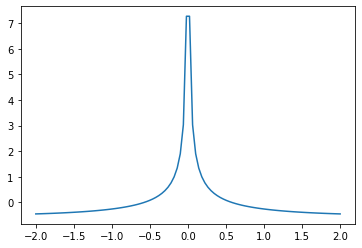

In [18]:
grad_f = grad(f)

x = np.linspace(-2, 2, 100)
plt.plot(x, [grad_f(x_) for x_ in x])

To use this in our optimization routines:

 - we can automatically compute gradients that the optimizer can use. 
 - Hessians can be exactly calculated


In [23]:
T = (np.random.exponential(size=1000)/1.5) ** 2.3
E = np.random.binomial(1, 0.95, size=1000)

In [24]:
def cumulative_hazard(params, t):
    lambda_, rho_ = params
    return (t / lambda_) ** rho_

def log_hazard(params, t):
    lambda_, rho_ = params
    return np.log(rho_) - np.log(lambda_) + (rho_ - 1) * (np.log(t) - np.log(lambda_))

def log_likelihood(params, t, e):
    return np.sum(e * log_hazard(params, t)) - np.sum(cumulative_hazard(params, t))

def negative_log_likelihood(params, t, e):
    return -log_likelihood(params, t, e)


In [25]:
from scipy.optimize import minimize

results = minimize(negative_log_likelihood, 
        x0 = np.array([1.0, 1.0]),
        method=None, 
        args=(T, E),
        jac=grad(negative_log_likelihood),
        bounds=((0., None), (0., None)))

print(results)

      fun: 220.5083259632587
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.34418257e-07, -1.42583474e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 11
      nit: 7
   status: 0
  success: True
        x: array([0.45588218, 0.43713049])


In [ ]:
from autograd import value_and_grad

results = minimize(
        value_and_grad(negative_log_likelihood), 
        x0 = np.array([1.0, 1.0]),
        method=None, 
        args=(T, E),
        jac=True,
        bounds=((0., None), (0., None)))
